In [1]:
#Date:  April 14, 2021
#Name:  Peida Han
#ID:    2449620842
#Email: peidahan@usc.edu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision as tv
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np

print(torch.cuda.is_available())
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)
print(device)

True
cuda:0


In [2]:
def load_MNIST_data(train_batch_size,test_batch_size):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081))])
    
    train_set=tv.datasets.MNIST(
        root='./data/',
        train=True,
        download=True,
        transform=transform
    )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_set=tv.datasets.MNIST(
        root='./data/',
        train=False,
        download=True,
        transform=transform
    )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )
    print('Data loaded')
    return train_loader,test_loader



In [3]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_MNIST_data(train_batch_size,test_batch_size)

trainData=[]
for index,data in enumerate(trainloader):
    label=data[1]    
    data1=torch.negative(data[0])
    trainData.append((data1,label))
    trainData.append((data[0],label))

Data loaded


In [4]:
train_batch_size=1
test_batch_size=1000
trainloader,testloader=load_MNIST_data(train_batch_size,test_batch_size)

testData=[]
posData=[]
negData=[]
for index,data in enumerate(testloader):
    label=data[1]
    testData.append([data[0],label]) 
    data1=torch.negative(data[0])    
    testData.append([data1,label])
    posData.append(data[0])
    negData.append(data1)


Data loaded


In [5]:
testPos=torch.cat(posData)
t=testPos.view(-1,1)
print('mean of original test data:', t.mean().numpy())
print('std of original test data:', t.std().numpy())
print('max of original test data:', t.max().numpy())
print('min of original test data:', t.min().numpy())

mean of original test data: 0.005889658
std of original test data: 1.0077257
max of original test data: 2.8214867
min of original test data: -0.42421296


In [6]:
testPos=torch.cat(negData)
t=testPos.view(-1,1)
print('mean of reversed test data:', t.mean().numpy())
print('std of reversed test data:', t.std().numpy())
print('max of reversed test data:', t.max().numpy())
print('min of reversed test data:', t.min().numpy())

mean of reversed test data: -0.005889658
std of reversed test data: 1.0077257
max of reversed test data: 0.42421296
min of reversed test data: -2.8214867


In [7]:
print('train data len:',len(trainData))
print('each train data size:',trainData[0][0].size())
print('test data len:',len(testData))
print('each test data size:',testData[0][0].size())

train data len: 12000
each train data size: torch.Size([10, 1, 28, 28])
test data len: 20
each test data size: torch.Size([1000, 1, 28, 28])


In [8]:
class CNN(nn.Module):

    def __init__(self,channel,size):
        super(CNN, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.size=size
        self.conv1 = nn.Conv2d(channel, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        if self.size==28:
            x=F.pad(x,(2,2,2,2))
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
def train(cnn,optimizer,criterion,trainloader,testloader,epoch,device):

    running_loss=0.0
    correct=0
    total=0
    iter=0
    for i, data in enumerate(trainloader,0):
        inputs,labels=data

        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs=cnn(inputs)

        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        predicted = torch.argmax(outputs, 1)
        
        corr = (predicted == labels)
        for j in range(labels.size(0)):
            if corr[j].item():
                correct+=1
            
        running_loss+=loss.item()
        iter=iter+1
        if iter%2000==1999:
            print('[%d, %5d] loss:%.5f'%(epoch+1,iter+1,running_loss/2000))
            running_loss=0
        total+=labels.size(0)
    train_acc=  correct/total     
    test_acc=predict(device,cnn,testloader)

    return train_acc,test_acc  

def predict(device,cnn,testloader):
    correct=0
    total=0
    with torch.no_grad():
        for data in testloader:
                inputs,labels=data
                inputs=inputs.to(device)
                labels=labels.to(device)
                labels=labels.float()

                outputs=cnn(inputs)
                predicted = torch.argmax(outputs, 1)

                corr = (predicted == labels)
                for i in range(labels.size(0)):
                    if corr[i].item():
                        correct=correct+1
                total+=labels.size(0)

    return correct/total       
    

In [9]:
def main(device,trainloader,testloader,channel,size,epochs,learning_rate,momentum,weight_decay):
    cnn=CNN(channel,size)
    cnn=cnn.to(device)
    
    optimizer = optim.SGD(cnn.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss().to(device)
    
    train_acc=[]
    test_acc=[]

    for epoch in range(epochs):        
        train_a,test_a=train(cnn,optimizer,criterion,trainloader,testloader,epoch,device)   
        train_acc.append(train_a*100)
        test_acc.append(test_a*100)
        print('epoch:',epoch+1,'train accuary:',train_a,' test accuary:',test_a)
    print('-----Training ends-----')
    plt.plot(train_acc,label='train acc')
    plt.plot(test_acc,label='test acc')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy %')
    plt.title('Performance Curve')
    plt.legend()
    plt.show()
    return train_acc,test_acc

def meanTrainResults(device,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay):
    multiple_train_acc=[]
    multiple_test_acc=[]

 
    start_time=time.time()
    train_acc,test_acc=main(device,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)
    multiple_train_acc.append(train_acc[-1])    
    multiple_test_acc.append(test_acc[-1])

    end_time=(time.time()-start_time)/60
    print('round:1 total time used:',end_time)

    best_acc_train=np.max(multiple_train_acc)
    print('Best train accuracy among 5 runs:',best_acc_train)
    best_acc_test=np.max(multiple_test_acc)
    print('Best test accuracy among 5 runs:',best_acc_test)


[1,  2000] loss:1.02546
[1,  4000] loss:0.16758
[1,  6000] loss:0.12102
[1,  8000] loss:0.09325
[1, 10000] loss:0.09323
[1, 12000] loss:0.08571
epoch: 1 train accuary: 0.9147583333333333  test accuary: 0.98065
[2,  2000] loss:0.07635
[2,  4000] loss:0.06410
[2,  6000] loss:0.06172
[2,  8000] loss:0.04728
[2, 10000] loss:0.05689
[2, 12000] loss:0.05484
epoch: 2 train accuary: 0.9813  test accuary: 0.985
[3,  2000] loss:0.05041
[3,  4000] loss:0.04336
[3,  6000] loss:0.04487
[3,  8000] loss:0.03434
[3, 10000] loss:0.04339
[3, 12000] loss:0.04215
epoch: 3 train accuary: 0.9869166666666667  test accuary: 0.98675
[4,  2000] loss:0.03898
[4,  4000] loss:0.03374
[4,  6000] loss:0.03673
[4,  8000] loss:0.02662
[4, 10000] loss:0.03601
[4, 12000] loss:0.03400
epoch: 4 train accuary: 0.9895583333333333  test accuary: 0.9884
[5,  2000] loss:0.02962
[5,  4000] loss:0.02704
[5,  6000] loss:0.03170
[5,  8000] loss:0.02287
[5, 10000] loss:0.02972
[5, 12000] loss:0.02707
epoch: 5 train accuary: 0.99125

[40,  2000] loss:0.00113
[40,  4000] loss:0.00102
[40,  6000] loss:0.00110
[40,  8000] loss:0.00035
[40, 10000] loss:0.00031
[40, 12000] loss:0.00060
epoch: 40 train accuary: 0.99975  test accuary: 0.9907
-----Training ends-----


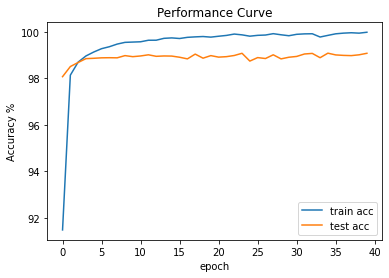

round:1 total time used: 18.262924393018086
Best train accuracy among 5 runs: 99.97500000000001
Best test accuracy among 5 runs: 99.07000000000001


In [10]:
channel=1
size=28
epoch=40
learning_rate=0.001
momentum=0.9
weight_decay=1e-5
meanTrainResults(device,trainData,testData,channel,size,epoch,learning_rate,momentum,weight_decay)


[1,  2000] loss:1.10426
[1,  4000] loss:0.17823
[1,  6000] loss:0.12495
[1,  8000] loss:0.10053
[1, 10000] loss:0.09272
[1, 12000] loss:0.08789
epoch: 1 train accuary: 0.9071833333333333  test accuary: 0.9809
[2,  2000] loss:0.07933
[2,  4000] loss:0.06760
[2,  6000] loss:0.06362
[2,  8000] loss:0.05068
[2, 10000] loss:0.05992
[2, 12000] loss:0.05657
epoch: 2 train accuary: 0.9801916666666667  test accuary: 0.9835
[3,  2000] loss:0.05408
[3,  4000] loss:0.04724
[3,  6000] loss:0.04555
[3,  8000] loss:0.03509
[3, 10000] loss:0.04536
[3, 12000] loss:0.04233
epoch: 3 train accuary: 0.986025  test accuary: 0.98525
[4,  2000] loss:0.03934
[4,  4000] loss:0.03518
[4,  6000] loss:0.03669
[4,  8000] loss:0.02736
[4, 10000] loss:0.03757
[4, 12000] loss:0.03544
epoch: 4 train accuary: 0.988675  test accuary: 0.9853
[5,  2000] loss:0.03050
[5,  4000] loss:0.02854
[5,  6000] loss:0.03104
[5,  8000] loss:0.02292
[5, 10000] loss:0.03114
[5, 12000] loss:0.03019
epoch: 5 train accuary: 0.99095  test a

[40,  2000] loss:0.00029
[40,  4000] loss:0.00033
[40,  6000] loss:0.00039
[40,  8000] loss:0.00030
[40, 10000] loss:0.00044
[40, 12000] loss:0.00036
epoch: 40 train accuary: 1.0  test accuary: 0.9923
[41,  2000] loss:0.00030
[41,  4000] loss:0.00033
[41,  6000] loss:0.00040
[41,  8000] loss:0.00031
[41, 10000] loss:0.00045
[41, 12000] loss:0.00036
epoch: 41 train accuary: 1.0  test accuary: 0.99215
[42,  2000] loss:0.00031
[42,  4000] loss:0.00034
[42,  6000] loss:0.00041
[42,  8000] loss:0.00031
[42, 10000] loss:0.00045
[42, 12000] loss:0.00037
epoch: 42 train accuary: 1.0  test accuary: 0.99225
[43,  2000] loss:0.00032
[43,  4000] loss:0.00035
[43,  6000] loss:0.00042
[43,  8000] loss:0.00032
[43, 10000] loss:0.00047
[43, 12000] loss:0.00039
epoch: 43 train accuary: 1.0  test accuary: 0.99225
[44,  2000] loss:0.00032
[44,  4000] loss:0.00036
[44,  6000] loss:0.00043
[44,  8000] loss:0.00033
[44, 10000] loss:0.00045
[44, 12000] loss:0.00040
epoch: 44 train accuary: 1.0  test accuary:

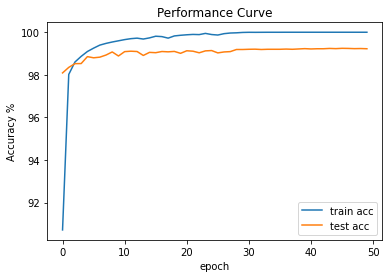

round:1 total time used: 22.954620643456778
Best train accuracy among 5 runs: 100.0
Best test accuracy among 5 runs: 99.225


In [11]:
channel=1
size=28
epoch=50
learning_rate=0.001
momentum=0.9
weight_decay=1e-4
meanTrainResults(device,trainData,testData,channel,size,epoch,learning_rate,momentum,weight_decay)
